In [42]:
import meld_graph.experiment
import os
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


In [43]:
model_path = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15_nothresh/ensemble_21-09-15'

In [44]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


In [45]:
n_vert = len(cohort.cortex_label)*2

In [47]:
file= os.path.join(model_path,f'fold_all', 'results', 'predictions_ensemble_iteration_0.hdf5')

with h5py.File(file, "r") as f:
    subjects = list(f.keys())
len(subjects)

453

In [48]:
def roc_curves(subject_dictionary,roc_dictionary,roc_curves_thresholds):
    """calculate performance at multiple thresholds"""
    
    for t_i,threshold in enumerate(roc_curves_thresholds):
        predicted = subject_dictionary['result']>= threshold
        # if we want tpr vs fpr curve too
        # tp,fp,fn, tn = tp_fp_fn_tn(predicted, subject_dictionary['input_labels'])
        #store sensitivity and sensitivity_plus for each patient (has a label)
        if subject_dictionary['input_labels'].sum()>0:
            roc_dictionary['sensitivity'][t_i] += np.logical_and(predicted, subject_dictionary['input_labels']).any()
            roc_dictionary['sensitivity_plus'][t_i] += np.logical_and(predicted, subject_dictionary['borderzone']).any()
        #store specificity for controls (no label)
        else:
            roc_dictionary['specificity'][t_i] += ~predicted.any()

In [49]:
#number of tresholds to evaluate ROC curve, between 0 & 1.
n_thresh=101
roc_curves_thresholds=np.linspace(0,1,n_thresh)
roc_dictionary={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.zeros(n_thresh)}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    s = MeldSubject(subj,cohort=cohort)
    labels_hemis = {}
    dists={}
    subject_results = np.zeros(n_vert)
    labels = np.zeros(n_vert)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    # for fold in folds:
    #     save_dir = save_dirs['spiral'][fold]
    #     pred_file = os.path.join(save_dir, 'predictions.hdf5')
    #     result_hemis = load_prediction(subj,pred_file, dset='prediction')
    #     subject_results += np.hstack([result_hemis['lh']/10,result_hemis['rh']/10])
    result_hemis = load_prediction(subj,file, dset='prediction_raw')
    subject_results =np.hstack([result_hemis['lh'],result_hemis['rh']])
    subject_dictionary={'input_labels':labels,'borderzone':borderzones,'result':subject_results}
    roc_curves(subject_dictionary,roc_dictionary,roc_curves_thresholds)
    

0
100
200
300
400


In [50]:
def optimal_threshold(b,roc_curves_thresholds):
    sensitivity_curve = b['sensitivity_plus']/max(b['sensitivity_plus'])
    specificity_curve = b['specificity']/max(b['specificity'])
    youden = sensitivity_curve + specificity_curve
    optimal_thresh = np.max(np.where(youden==np.max(youden)))
    return sensitivity_curve,specificity_curve,optimal_thresh

In [51]:
def plot_roc(sensitivity_curve,specificity_curve,optimal_thresh,roc_curves_thresholds):
    fig, axes = plt.subplots(1,2)
    axes = axes.ravel()
    axes[0].plot(1-specificity_curve,sensitivity_curve,)
    axes[0].scatter(1-specificity_curve[optimal_thresh],sensitivity_curve[optimal_thresh], c='r')
    axes[1].plot(roc_curves_thresholds,sensitivity_curve,label='sensitivity')
    axes[1].plot(roc_curves_thresholds,specificity_curve,label='specificity')
    axes[1].plot(roc_curves_thresholds,specificity_curve+sensitivity_curve-1,label='Youden')
    axes[1].plot([roc_curves_thresholds[optimal_thresh],roc_curves_thresholds[optimal_thresh]],
    [0,1],label='Optimal threshold')
    fig.legend()
    return fig

0.65 0.6010362694300518


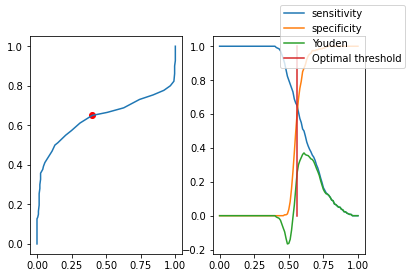

In [56]:
#get optimal threshold. This might not be the best way to do it
sensitivity_curve,specificity_curve,optimal_thresh= optimal_threshold(roc_dictionary,roc_curves_thresholds=roc_curves_thresholds)
#this fixed value is what we used for iec.
optimal_thresh=(56)
f=plot_roc(sensitivity_curve,specificity_curve,optimal_thresh,roc_curves_thresholds)
print(sensitivity_curve[optimal_thresh],specificity_curve[optimal_thresh])

In [1]:
class EnsembleModel:
    def __init__(self, model_path):
        """model path doesn't contain the fold bit. this is then looped over"""
        #load models
        self.models=[]
        for fold in np.arange(10):
            fold_path = os.path.join(model_path,f'fold_0{fold}')
            exp = meld_graph.experiment.Experiment.from_folder(fold_path)
            exp.load_model(
                        checkpoint_path=os.path.join(fold_path, "best_model.pt"),
                        force=True,
                    )
            self.models.append(exp.model)
        self.network_parameters = exp.network_parameters

    def predict(self,data):
        """function to predict and average"""
        predictions=[]
        distance_maps=[]
        for model in self.models:
            estimates = model(data)
            predictions.append(torch.exp(estimates['log_softmax'])[:,1].numpy)
            #get distance map if exist in loss, otherwise return array of NaN
            if 'distance_regression' in self.network_parameters['training_parameters']['loss_dictionary'].keys():
                distance_map = estimates['non_lesion_logits'][:,0]
            else: 
                distance_map = torch.full((len(prediction),1), torch.nan)[:,0]
            distance_maps = 

In [7]:
models=[]
for fold in np.arange(10):
    fold_path = os.path.join(model_path,f'fold_0{fold}')
    exp = meld_graph.experiment.Experiment.from_folder(fold_path)
    exp.load_model(
                checkpoint_path=os.path.join(fold_path, "best_model.pt"),
                force=True,
            )
    models.append(exp.model)

Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_00/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_01/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_02/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-01-13_QXFB_kernel_GMM_fold/s_2/fold_03/best_model.pt
Initialised Experiment 23-01-13_QXFB_kernel_GMM_fold/s_2
Creating model
Loading model weights from check

NameError: name 'data' is not defined